# 画像処理のテスト

dataフォルダに格納されているdogとcatの2クラスの画像を分類するモデルを作成せよ。

サンプル数

- dog: 250枚
- cat: 250枚

訓練データ: 全体の70%をランダムに（seed=0）

AccuracyがValidationのデータに対して70%得られていること

In [1]:
from glob import glob
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import chainer
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_dir = '../new_dataset/dataset/data/'

os.listdir(data_dir)

['validation', 'test.zip', 'train']

In [3]:
train_dogs = glob(os.path.join(data_dir, 'train/dog/*.jpg'))
train_cats = glob(os.path.join(data_dir, 'train/cat/*.jpg'))
valid_dogs = glob(os.path.join(data_dir, 'validation/dog/*.jpg'))
valid_cats = glob(os.path.join(data_dir, 'validation/cat/*.jpg'))

len(train_dogs), len(train_cats), len(valid_dogs), len(valid_cats)

(1000, 1000, 400, 400)

### データの確認

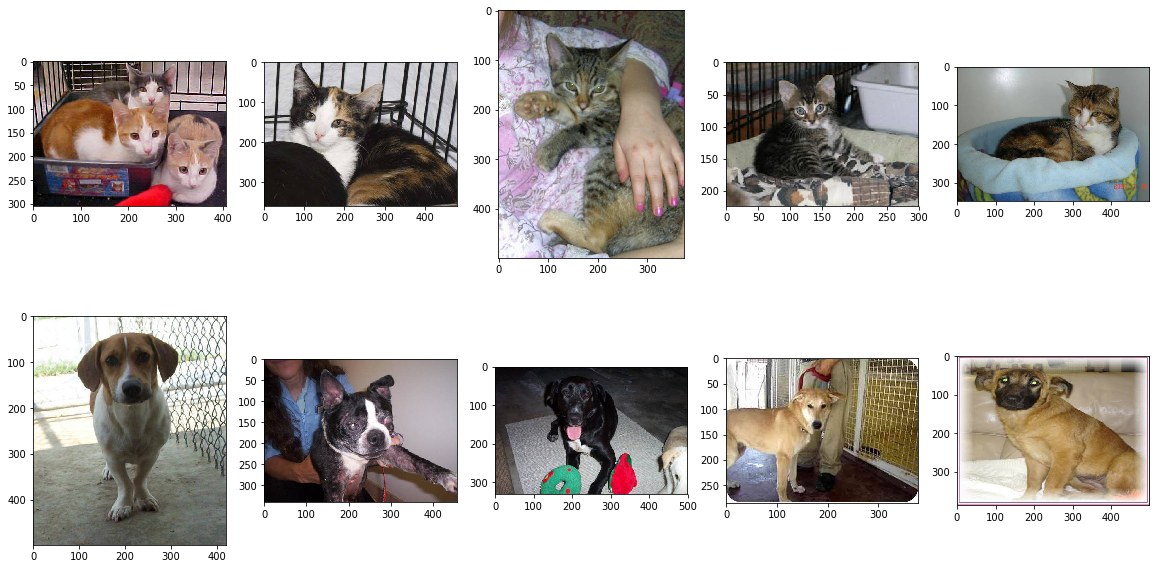

In [4]:
# サンプル的に画像を見てみる
np.random.seed(0)
plt.figure(figsize=(20, 10))
for i in range(5):
    sample_cat = np.random.choice(train_cats)
    sample_img = Image.open(sample_cat)
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_img)
    
    sample_dog = np.random.choice(train_dogs)
    sample_img = Image.open(sample_dog)
    plt.subplot(2, 5, i+6)
    plt.imshow(sample_img)

plt.show()

気づいたこと
* 正方形に加工されている様子
* 全身の画像や顔などの一部だけ写ってる画像もある
* うさぎも写っているものもある
* 肉球もある

In [5]:
# 犬猫データの結合
train_label = {
    'cat': 1,
    'dog': 0}

df = pd.DataFrame({
    'file_path': train_cats + train_dogs + valid_dogs + valid_cats,
})
df['label'] = df['file_path'].str.split('/', expand=True)[5]
df['dataset'] = df['file_path'].str.split('/', expand=True)[4]
df['target'] = df['label'].replace(train_label)
df.shape

(2800, 4)

In [6]:
df.head()

,file_path,label,dataset,target
0,../new_dataset/dataset/data/train/cat/train_ca...,cat,train,1
1,../new_dataset/dataset/data/train/cat/train_ca...,cat,train,1
2,../new_dataset/dataset/data/train/cat/train_ca...,cat,train,1
3,../new_dataset/dataset/data/train/cat/train_ca...,cat,train,1
4,../new_dataset/dataset/data/train/cat/train_ca...,cat,train,1


In [7]:
df.tail()

,file_path,label,dataset,target
2795,../new_dataset/dataset/data/validation/cat/val...,cat,validation,1
2796,../new_dataset/dataset/data/validation/cat/val...,cat,validation,1
2797,../new_dataset/dataset/data/validation/cat/val...,cat,validation,1
2798,../new_dataset/dataset/data/validation/cat/val...,cat,validation,1
2799,../new_dataset/dataset/data/validation/cat/val...,cat,validation,1


In [8]:
# 画像サイズを調べる
for i, row in df.iterrows():
    img = cv2.imread(row['file_path'])
    df.loc[i, 'height'] = img.shape[0]
    df.loc[i, 'width'] = img.shape[1]
    df.loc[i, 'channel'] = img.shape[2]

In [9]:
df.iloc[np.random.choice(df.index, 5)]

,file_path,label,dataset,target,height,width,channel
277,../new_dataset/dataset/data/train/cat/train_ca...,cat,train,1,359.0,306.0,3.0
1778,../new_dataset/dataset/data/train/dog/train_do...,dog,train,0,458.0,499.0,3.0
1828,../new_dataset/dataset/data/train/dog/train_do...,dog,train,0,374.0,500.0,3.0
2647,../new_dataset/dataset/data/validation/cat/val...,cat,validation,1,375.0,499.0,3.0
2648,../new_dataset/dataset/data/validation/cat/val...,cat,validation,1,375.0,499.0,3.0


In [10]:
df['height'].unique(), df['width'].unique(), df['channel'].unique()

(array([375., 479., 324., 409., 234., 285., 499., 345., 198., 349., 410.,
        343., 199., 475., 308., 374., 149., 244., 200., 477., 320., 243.,
        455., 378., 225., 500., 270., 239., 380., 280., 260., 336., 429.,
        255., 476., 286.,  89., 157., 368., 438., 300., 493., 357., 290.,
        289., 232., 264., 447., 457., 427., 478., 433., 405., 396., 240.,
        417., 482., 440., 190., 181., 294., 337., 229., 373., 262., 319.,
        119., 331., 388., 256., 421.,  93., 391., 431., 251., 460., 359.,
        248., 140., 386., 222., 332., 214.,  94.,  95., 411., 196., 127.,
        269., 208., 346., 210., 333., 445., 291., 492., 371., 305., 430.,
        224., 424., 159., 436., 304., 454., 358., 425., 397., 295., 245.,
        382., 175., 228., 399., 461., 129., 387., 488., 497., 272., 258.,
        400., 177., 377., 297., 172., 102., 451., 381., 384., 473., 195.,
        372., 213., 449., 223., 318., 383., 230., 249., 288., 299., 335.,
        284., 156., 116., 342., 117., 

* すべて同じサイズ・チャネル数も同じ画像と確認
* サイズがばらばら

In [11]:
from chainer.datasets import TupleDataset

In [12]:
df['target'].value_counts()

1    1400
0    1400
Name: target, dtype: int64

In [13]:
train_df = df[df['dataset'] == 'train'].copy()
valid_df = df[df['dataset'] == 'validation'].copy()
valid_df = valid_df.reset_index()

train = TupleDataset(train_df['file_path'], train_df['target'].astype('int32'))
valid = TupleDataset(valid_df['file_path'], valid_df['target'].astype('int32'))

In [14]:
valid[0]

('../new_dataset/dataset/data/validation/dog/val_dog0282.jpg', 0)